In [ ]:
import argparse
import os
import sys
import random
sys.path.append(".")
import numpy as np
import time
import torch as th
import intel_extension_for_pytorch as ipex
from guided_diffusion.bratsloader import BRATSDataset3D_midslice
import torchvision.utils as vutils
from guided_diffusion.utils import staple
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)
import torchvision.transforms as transforms

In [ ]:
seed=10
th.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
def create_argparser():
    defaults = dict(
        data_name = 'BRATS',
        data_dir="../dataset/brats2020/testing",
        clip_denoised=True,
        num_samples=1,
        batch_size=1,
        use_ddim=False,
        model_path="",         #path to pretrain model
        num_ensemble=5,      #number of samples in the ensemble
        gpu_dev = "0",
        out_dir='./results/',
        multi_gpu = None,
        debug = False
    )
    defaults.update(model_and_diffusion_defaults())
    parser = argparse.ArgumentParser()
    add_dict_to_argparser(parser, defaults)
    return parser

In [ ]:
args = create_argparser().parse_args()

In [ ]:
tran_list = [transforms.Resize((256,256)),]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset3D_midslice('data/MICCAI_BraTS2020_TrainingData',transform_test)

datal = th.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)
data = iter(datal)

# print(args.batch_size)

# model, diffusion = create_model_and_diffusion(
#     **args_to_dict(args, model_and_diffusion_defaults().keys())
# )

######################
# state_dict = dist_util.load_state_dict(args.model_path, map_location="cpu")
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     # name = k[7:] # remove `module.`
#     if 'module.' in k:
#         new_state_dict[k[7:]] = v
#         # load params
#     else:
#         new_state_dict = state_dict

# model.load_state_dict(new_state_dict)
######################

# model.eval()
# model = ipex.optimize(model, dtype=th.bfloat16)

for _ in range(len(data)):
    b, m, path = next(data)  #should return an image from the dataloader "data"
    c = th.randn_like(b[:, :1, ...])
    img = th.cat((b, c), dim=1)     #add a noise channel$

    slice_ID=path[0].split("_")[-2]

    # enslist = []

    # for i in range(args.num_ensemble):  #this is for the generation of an ensemble of 5 masks.
    #     model_kwargs = {}
    #     start_time = time.time()

    #     print("sample " + str(i))
    #     sample_fn = (
    #         diffusion.p_sample_loop_known if not args.use_ddim else diffusion.ddim_sample_loop_known
    #     )

    #     with th.no_grad(), th.cpu.amp.autocast():
    #         sample, x_noisy, org, cal, cal_out = sample_fn(
    #             model,
    #             (args.batch_size, args.in_ch, args.image_size, args.image_size), img,
    #             step = args.diffusion_steps,
    #             clip_denoised=args.clip_denoised,
    #             model_kwargs=model_kwargs,
    #         )

    #     print("--- %s seconds ---" % (time.time() - start_time))

    #     co = th.tensor(cal_out)
    #     if args.version == 'new':
    #         enslist.append(sample[:,-1,:,:])
    #     else:
    #         enslist.append(co)

    # ensres = staple(th.stack(enslist,dim=0)).squeeze(0)
    # vutils.save_image(ensres, fp = os.path.join(args.out_dir, str(slice_ID)+'_output_ens'+".jpg"), nrow = 1, padding = 10)

    # Extract the four images
    import matplotlib.pyplot as plt
    image_0 = b[0, 0].squeeze().cpu().numpy()
    image_1 = b[0, 1].squeeze().cpu().numpy()
    image_2 = b[0, 2].squeeze().cpu().numpy()
    image_3 = b[0, 3].squeeze().cpu().numpy()

    # Create a 2x2 grid of subplots
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(image_0, cmap='gray')
    plt.title("Image 0")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(image_1, cmap='gray')
    plt.title("Image 1")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(image_2, cmap='gray')
    plt.title("Image 2")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(image_3, cmap='gray')
    plt.title("Image 3")
    plt.axis('off')

    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()
    
    break

In [ ]:
from PIL import Image
im = Image.fromarray(image_0)
im = im.convert('RGB')
im.save("your_file.jpg")

In [ ]:
import matplotlib.image
matplotlib.image.imsave('your_file.jpg', m.squeeze().cpu().numpy())

In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread('your_file.jpg')
plt.imshow(img, cmap='gray')

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

test_load = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii.gz').get_fdata()
test_seg = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii.gz').get_fdata()

In [ ]:
from scipy import ndimage
rotated_img = ndimage.rotate(test_load[:,:,int(155/2)], -90)
rotated_seg = ndimage.rotate(test_seg[:,:,int(155/2)], -90)
plt.imshow(rotated_img, cmap='gray')
plt.show()

In [ ]:
rotated_seg[rotated_seg>rotated_seg.mean()] = 1

In [ ]:
rotated_seg[rotated_seg>rotated_seg.mean()] = 1
plt.imshow(rotated_img, cmap='gray')
plt.imshow(rotated_seg, cmap='jet', interpolation='none',alpha=0.5)
plt.show()

In [ ]:
rotated_img.shape

In [ ]:
from segmentation_mask_overlay import overlay_masks
fig = overlay_masks(rotated_img, rotated_seg, colors = 'r', beta = .8, return_type="numpy")

In [ ]:
plt.imshow(fig)

In [ ]:
path = 'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
for root, dirs, files in os.walk(path):
    files.sort()
    print(files)
    # datapoint = dict()
    # # extract all files as channels
    # for f in files:
    #     seqtype = f.split('_')[3].split('.')[0]
    #     datapoint[seqtype] = os.path.join(root, f)

In [ ]:
dir_list = os.listdir(path)
dir_list.sort()
datapoint = dict()
for f in dir_list:
    seqtype = f.split('_')[3].split('.')[0]
    datapoint[seqtype] = os.path.join(root, f)

assert set(datapoint.keys()) == set(['t1', 't1ce', 't2', 'flair', 'seg'])
                                 

In [ ]:
import torch
import intel_extension_for_pytorch as ipex
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset3D_midslice

batch_size = 128
in_ch = 4
img_size = 256

tran_list = [transforms.Resize((img_size,img_size))]
transform_test = transforms.Compose(tran_list)

training_data = BRATSDataset3D_midslice('data/MICCAI_BraTS2020_TrainingData/',transform_test)


training_dataset = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True)

validation_data = BRATSDataset3D_midslice('data/MICCAI_BraTS2020_ValidationData/',transform_test, test_flag=True)

validation_dataset = DataLoader(
    validation_data,
    batch_size=batch_size,
    shuffle=True)

# Set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
from guided_diffusion.unet_parts import BasicUNet
model = BasicUNet(n_channels=in_ch, n_classes=1).to(device)
# print(model)


loss_fn = nn.BCEWithLogitsLoss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
    
    for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(torch.float32).to(device), y.to(torch.float32).to(device)

        # Compute prediction error
        with torch.cpu.amp.autocast():
            pred = model(X)
            # import pdb
            # pdb.set_trace()
            loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        torch.save(model.state_dict(), "model_0.pth")

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     model = ipex.optimize(model, dtype=torch.bfloat16)
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y, _ in dataloader:
#             X, y = X.to(torch.float32).to(device), y.to(torch.float32).to(device)
#             with torch.cpu.amp.autocast():
#                 pred = model(X)
#                 test_loss += loss_fn(pred, y).item()
#                 correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
#     return test_loss
    
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
lowest_loss = 1e9
epochs = 200

import time

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    start = time.time()
    train(training_dataset, model, loss_fn, optimizer)
    end = time.time()
    print(end - start)
    
#     start = time.time()
#     test_loss = test(validation_dataset, model, loss_fn)
#     end = time.time()
#     print(end - start)
    
#     if test_loss < lowest_loss:
#         lowest_loss = test_loss
    torch.save(model.state_dict(), "model.pth")
    print("Saved PyTorch Model State to model.pth")

print("Done!")

In [ ]:
import torch
import intel_extension_for_pytorch as ipex
from torch import nn

seed=42
torch.manual_seed(seed)

from guided_diffusion.unet_parts import BasicUNet
model = BasicUNet(n_channels=4, n_classes=1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


print(model.inc.double_conv[0].weight[0].mean())
model.train()
model_ipex, optimizer_ipex = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
print(model_ipex.inc.double_conv[0].weight[0].mean())

checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(model.inc.double_conv[0].weight[0].mean())
model.train()
model_ipex, optimizer_ipex = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
print(model_ipex.inc.double_conv[0].weight[0].mean())

In [ ]:
seed=42
torch.manual_seed(seed)

from guided_diffusion.unet_parts import BasicUNet
model = BasicUNet(n_channels=4, n_classes=1)
print(model_ipex.inc.double_conv[0].weight[0].mean())
# load_model(model)

def load_model(model):
    model.train
    model_ipex, optimizer_ipex = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
    print(model_ipex.inc.double_conv[0].weight[0].mean())
#     for name, param in model.named_parameters():
#         print(param.mean())

for _ in range(5):
    load_model(model)
    checkpoint = torch.load('model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
from guided_diffusion.unet_parts import BasicUNet
model = BasicUNet(n_channels=4, n_classes=1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

checkpoint = torch.load('model.pth')

# print(optimizer.state_dict())
# print('-------')
# model_ipex, optimizer_ipex = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
# print(optimizer_ipex.state_dict())

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print(optimizer.state_dict())
# print('-------')
model_ipex, optimizer_ipex = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
print(optimizer_ipex.state_dict())
print('-------')
optimizer_ipex.load_state_dict(checkpoint['optimizer_state_dict'])
print(optimizer_ipex.state_dict())

In [ ]:
for name, param in model.named_parameters():
    print(param.mean())

In [ ]:
import gradio as gr

# def segment_organs(input_img, dropdown):
#     # Loading a nifti in the traditional sense
#     slice1_num =  150

#     t1 = time()
#     segmentation, im_path = process_case(input_img.name)
#     t2 = time()
#     print((t2-t1)/60)
#     slice1 = np.squeeze(segmentation[:, :, slice1_num])
#     slice1_float = (slice1 - np.min(slice1)) /(np.max(slice1) - np.min(slice1)) 

#     return "mesh_test.obj", im_path

def segment_organs(input_img, dropdown):
    return('Hello world')

demo = gr.Interface(segment_organs, 
    ["file", gr.Dropdown(['UNET', 'UNETR'], label="Model")], 
    [gr.Model3D(), "image"], 
    live=False, 
    title="Organ segmentation with UNET/UNETR")

demo.launch(share=False, server_name="0.0.0.0")
# demo.launch(share=False, server_name="0.0.0.0", server_port=8889)

In [1]:
import torch

seed=42
torch.manual_seed(seed)

from guided_diffusion.unet_parts import BasicUNet
model = BasicUNet(n_channels=4, n_classes=1)
checkpoint = torch.load('model_nonnormalized.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('model_nonnormalized.pth', map_location=torch.device('cpu')))
model.eval()

BasicUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

tensor(96.8489, grad_fn=<MulBackward0>)


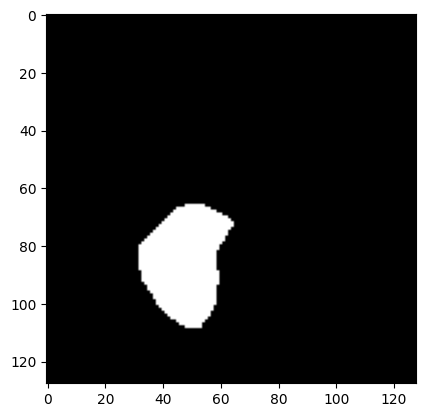

In [5]:
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset

tran_list = [transforms.Resize((128,128)),]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_333', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

import matplotlib.pyplot as plt
from scipy import ndimage
import torch.nn.functional as F
from guided_diffusion.utils import dice_coeff
# sigmoid = torch.nn.Sigmoid()

b, m, slide_id = next(iter(datal))

m_pred = F.sigmoid(model(b.to(torch.float32)))
print(dice_coeff(m_pred, m.int())*100)

import matplotlib.pyplot as plt
mask = ndimage.rotate(m_pred.detach().squeeze().cpu().numpy(), -90)
mask[mask > (mask.max() + mask.min())/2] = 1
mask[mask != 1] = 0
plt.imshow(mask, cmap='gray')

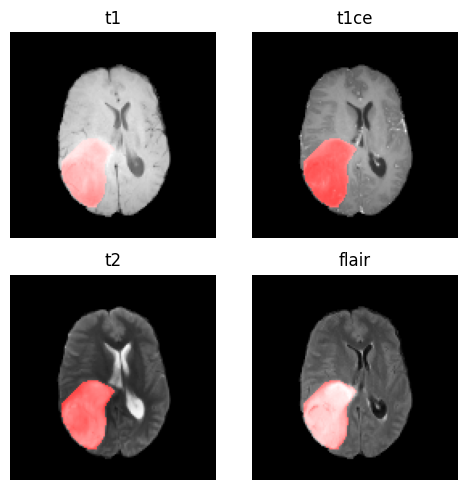

In [6]:
import matplotlib.pyplot as plt
from scipy import ndimage

image_0 = ndimage.rotate(b[0, 0].squeeze().cpu().numpy(), -90)
image_1 = ndimage.rotate(b[0, 1].squeeze().cpu().numpy(), -90)
image_2 = ndimage.rotate(b[0, 2].squeeze().cpu().numpy(), -90)
image_3 = ndimage.rotate(b[0, 3].squeeze().cpu().numpy(), -90)

# mask = ndimage.rotate(m.squeeze().cpu().numpy(), -90)

from segmentation_mask_overlay import overlay_masks
image_0 = overlay_masks(image_0, mask, colors = 'r', beta = .8, return_type="numpy")
image_1 = overlay_masks(image_1, mask, colors = 'r', beta = .8, return_type="numpy")
image_2 = overlay_masks(image_2, mask, colors = 'r', beta = .8, return_type="numpy")
image_3 = overlay_masks(image_3, mask, colors = 'r', beta = .8, return_type="numpy")

# Create a 2x2 grid of subplots
plt.figure(figsize=(5, 5))

plt.subplot(2, 2, 1)
plt.imshow(image_0, cmap='gray')
plt.title("t1")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(image_1, cmap='gray')
plt.title("t1ce")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image_2, cmap='gray')
plt.title("t2")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image_3, cmap='gray')
plt.title("flair")
plt.axis('off')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

In [28]:
import os
dir_list = os.listdir("data/MICCAI_BraTS2020_TrainingData/")
dir_list[0]

'BraTS20_Training_053'

In [1]:
import os
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.unet_parts import BasicUNet
import torch.nn.functional as F
from guided_diffusion.utils import dice_coeff

seed=42
torch.manual_seed(seed)

model = BasicUNet(n_channels=4, n_classes=1)
checkpoint = torch.load('model_nonnormalized.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

tran_list = [transforms.Resize((128,128)),]
transform_test = transforms.Compose(tran_list)

basePath = "data/MICCAI_BraTS2020_TrainingData/"
dir_list = os.listdir(basePath)

dice_scores = dict()

for d in dir_list:
    if os.path.isdir(os.path.join(basePath, d)):
        ds = BRATSDataset(os.path.join(basePath, d), transform_test)

        datal = torch.utils.data.DataLoader(
            ds,
            batch_size=1,
            shuffle=True)

        b, m, slide_id = next(iter(datal))

        m_pred = F.sigmoid(model(b.to(torch.float32)))

        dice_scores.update({d : (dice_coeff(m_pred, m.int())*100).item()})
        # print(dice_coeff(m_pred, m.int())*100)

/home/u101753/.conda/envs/MedSegDiff/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
Keymax = max(zip(dice_scores.values(), dice_scores.keys()))[1]
print(Keymax)
print(dice_scores[Keymax])

BraTS20_Training_333
96.84893798828125
